# Only using time series and some categorical features

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import datetime
from itertools import groupby

sns.set(style="white")

In [2]:
pwd

'C:\\Projects\\sarawak_energy\\notebook'

In [19]:
data_source_dir = "../data"
output_source_dir = "../output"
plot_dir = "../plots"

In [20]:
def GetFile(file, directory=data_source_dir):
    return os.path.join(directory, file)

In [21]:
xls = pd.ExcelFile(GetFile("sarawak_energy.xlsx"))

df_dict = {}
for sheet_name in xls.sheet_names:
    df_dict[sheet_name] = xls.parse(sheet_name)

In [22]:
def cleanse_df_cp(df_cp):
    
    non_null_cols = df_cp.isna().all()[df_cp.isna().all()==False].index.tolist()
    df_cp = df_cp[non_null_cols]
    df_cp.drop(["MoveIn", "MoveOut", "billing_factor"], inplace=True, axis = 1)
    
    df_cp["was_fraud"] = df_cp["was_fraud"].replace("S", 1)
    df_cp["was_fraud"] = df_cp["was_fraud"].replace(np.nan, 0)
    df_cp["was_fraud"] = df_cp["was_fraud"].astype(int)
    
    df_cp.rename(columns={'id':'id_uc'}, inplace=True)
    
    return df_cp

In [23]:
def cleanse_df_bp(df_bp):
    
    non_null_cols = df_bp.isna().all()[df_bp.isna().all()==False].index.tolist()

    df_bp = df_bp[non_null_cols]
    
    # replacing the nans with zeros
    df_bp.replace(np.nan, 0.0, inplace=True)
    
    return df_bp

In [24]:
def cleanse_df(df_dict):
    
    df_cp = cleanse_df_cp(df_dict['Consumption_Point_Data_Package'])
        
    df_bp = cleanse_df_bp(df_dict['Billing_Data_Package'])
    
    months_count =df_bp.groupby(['id_uc']).count()['date_reference'].reset_index()
    customers_filtered = list(months_count.query('date_reference >= 6')['id_uc'].unique())
    df_cp_filtered = df_cp[df_cp["id_uc"].isin(customers_filtered)]
    df_bp_filtered = df_bp[df_bp["id_uc"].isin(customers_filtered)]
    
    return df_cp, df_bp

In [25]:
def last_day(d):
    
    last = datetime.date(d.year + d.month // 12, d.month % 12 + 1, 1) - datetime.timedelta(1)
    return pd.to_datetime(last)
    

In [26]:
df_cp_filtered, df_bp_filtered = cleanse_df(df_dict)

C:\Users\jc17642\Anaconda3\envs\stat8017\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-22-651876c10a9c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cp["was_fraud"] = df_cp["was_fraud"].replace("S", 1)
<ipython-input-22-651876c10a9c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [28]:
y = df_cp_filtered[['id_uc', 'was_fraud']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

df_bp_ts = df_bp_filtered.sort_values(['id_uc', 'date_reference']).drop(['date_measured', 'ReadType'], axis=1)

assert (len(y) == len(df_bp_ts['id_uc'].unique())), print("unique elements do not match")

In [31]:
y

id_uc  was_fraud
328  100000023146          0
327  100000106908          0
326  100000328929          0
325  100000420500          0
324  100000597035          0
..            ...        ...
333  401005754120          1
332  401016009113          1
331  401017049106          1
330  401021326106          1
329  401048279102          1

[350 rows x 2 columns]

In [29]:
df_bp_ts['date_reference'] = df_bp_ts['date_reference'].apply(last_day)

In [32]:
df_bp_ts

id_uc date_reference      Read    Billed  consumption_invoiced  \
0      100000023146     2016-08-31       0.0       0.0                   0.0   
1      100000023146     2016-09-30       0.0       0.0                   0.0   
2      100000023146     2016-10-31    3009.0    3009.0                3009.0   
3      100000023146     2016-11-30    5015.0    5015.0                2006.0   
4      100000023146     2016-12-31    7021.0    7021.0                2006.0   
...             ...            ...       ...       ...                   ...   
19797  401048279102     2017-12-31  233680.0  233680.0                1141.0   
19798  401048279102     2018-01-31  235331.0  235331.0                1651.0   
19799  401048279102     2018-02-28  236752.0  236752.0                1421.0   
19800  401048279102     2018-03-31  238266.0  238266.0                1514.0   
19801  401048279102     2018-04-30  239942.0  239942.0                 879.5   

       consumption_measured  value_measured  
0                       0.0             0.0  
1                       0.0             0.0  
2                    3009.0          3009.0  
3                    2006.0          5015.0  
4                    2006.0          7021.0  
...                     ...             ...  
19797                1141.0        233680.0  
19798                1651.0        235331.0  
19799                1421.0        236752.0  
19800                1514.0        238266.0  
19801                 879.5        239942.0  

[19802 rows x 7 columns]

In [30]:
df_bp_ts.reset_index(drop=True, inplace=True)

df_bp_ts = df_bp_ts.groupby('id_uc').resample('M', on="date_reference").mean()
df_bp_ts = df_bp_ts.drop(['id_uc'], axis=1).reset_index()

df_bp_ts = df_bp_ts.replace(np.NaN, 0)


In [14]:
def len_iter(items):
    return sum(1 for _ in items)

def consecutive_zero(data):
    x = list((len_iter(run) for val, run in groupby(data) if val==0))
    if len(x)==0: return 0 
    else: return max(x)
    
def consecutive_negative(data):
    x = list((len_iter(run) for val, run in groupby(data) if val<0))
    if len(x)==0: return 0 
    else: return max(x)
    
def consecutive_low(data):
    x = list((len_iter(run) for val, run in groupby(data) if val==True))
    if len(x)==0: return 0 
    else: return max(x)
    
def cleanse_ts(ts):
    
    try:
        ts = ts.mask(ts <= 0, np.nan).interpolate(limit_direction='both')
    except:
        return np.NaN

    return ts

def cleanse_ts_series(ts):
    
    try:
        ts = ts.mask(ts <= 0, np.nan).interpolate(limit_direction='both')
    except:
        return np.NaN

    return ts

def sharp_drops_count(ts, series=False):
    a = .7

    try:
        d = pd.Series(ts.values[1:] - ts.values[:-1], index=ts.index[:-1]).abs()
        r = d.rolling(3, min_periods=1, win_type='parzen').sum()
        n = r.max()
    except:
        return np.NaN
    
    if series:
        return (r > n* a)
    else:
        return sum(r > n * a)

def highest_con_dif(ts):
    
    try:
        hcd = abs(min(ts - ts.shift(-1) ) / np.mean(ts))
    
    except:
        return np.NaN
    
    return hcd

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [15]:
def ts_feature_engineering(df, test=True):
    """
    Function for feature engineering of time series. Those that involves counts are expressed in %
    """
    # number of records
    records = int(len(df))
    
    # negatives represent a meter was reset
    negatives = np.mean(df['consumption_measured'] < 0) 
    
    # number of zeros in the ts. Zeros represent unknown or estimated figure
    zeros = np.mean(df['consumption_measured'] == 0) 
    
    # consecutive zeros percentage in consumption measured, consecituve zeros / number of records
    #https://stackoverflow.com/questions/51605651/find-longest-run-of-consecutive-zeros-for-each-user-in-dataframe
    consecutive_zeros = consecutive_zero(df['consumption_measured']) / records
    
    # consumption measured != consumption billed and consumption measured is positive
    #consumption_difference = sum(df[df['consumption_invoiced']!=df['consumption_measured']]['consumption_measured']>0) / records
    
    # features that needs a cleansed time series
    ts = cleanse_ts(df['consumption_measured'])
    
    # sharp drop count
    sdc = sharp_drops_count(ts) / records
    
    # number of low periods count
    lpc = consecutive_low( sharp_drops_count(ts, True)) / records
    # number of peaks
    
    
    # highest consecutive difference / average 
    hcd = highest_con_dif(ts)
    
    # vs average of region, locality, municipality
    # MAPE vs municipality
    if test:
        ts_local = df.set_index('date_reference').apply(cleanse_ts)[['id_uc', 'consumption_measured']].reset_index().merge(locations_test, on='id_uc', how='left')
        ts_local = ts_local.merge(locations_ts_test['id_locality'], on=['id_locality', 'date_reference'])
    else:
        ts_local = df.set_index('date_reference').apply(cleanse_ts)[['id_uc', 'consumption_measured']].reset_index().merge(locations, on='id_uc', how='left')
        ts_local = ts_local.merge(locations_ts['id_locality'], on=['id_locality', 'date_reference'])
        
    mapd_local = mean_absolute_percentage_error(ts_local['consumption_measured_x'], ts_local['consumption_measured_y'])
    
    series_dict = {'records':records ,'negatives':negatives, 'zeros':zeros, 
                   'consecutive_zeros': consecutive_zeros,
                   'sharp_drop': sdc, 'consecutive_low': lpc, 'highest_con_diff': hcd, 'mapd_local': mapd_local
                  
                  }
    
    
    return pd.Series(series_dict)

In [16]:
locations = df_cp_filtered[['id_uc', 'id_region','id_locality', 'id_municipality']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

main_ts = df_bp_ts[['id_uc', 'date_reference', 'consumption_measured']].set_index('date_reference').groupby('id_uc').apply(cleanse_ts).reset_index()

main_ts = main_ts.merge(locations, on='id_uc', how='left')

locations_ts = {}

for location in ['id_region', 'id_locality', 'id_municipality']:
    
    locations_ts[location] = main_ts[['date_reference', 'consumption_measured', 'id_region', 'id_locality', 'id_municipality']].groupby([location]).resample('M', on="date_reference").mean().drop(['id_region'], axis=1).reset_index()

In [17]:
df_bp_ts['id_uc_2'] = df_bp_ts['id_uc'].copy()

ts_features = df_bp_ts.groupby('id_uc_2').apply(ts_feature_engineering, test=False)
ts_features = ts_features.reset_index().rename(columns={'id_uc_2':'id_uc'})

ts_features['id_uc'] = ts_features['id_uc'].astype(str)

In [18]:
ts_features

id_uc  records  negatives     zeros  consecutive_zeros  \
0    100000023146     26.0   0.038462  0.115385           0.076923   
1    100000106908     89.0   0.011236  0.022472           0.011236   
2    100000328929    183.0   0.016393  0.158470           0.005464   
3    100000420500      1.0   0.000000  1.000000           1.000000   
4    100000597035    129.0   0.000000  0.449612           0.224806   
..            ...      ...        ...       ...                ...   
345  401005754120     48.0   0.000000  0.083333           0.062500   
346  401016009113    188.0   0.010638  0.005319           0.005319   
347  401017049106    179.0   0.027933  0.033520           0.022346   
348  401021326106    190.0   0.005263  0.010526           0.005263   
349  401048279102    193.0   0.005181  0.005181           0.005181   

     sharp_drop  consecutive_low  highest_con_diff  mapd_local  
0      0.115385         0.038462          0.599139    2.482151  
1      0.044944         0.022472          0.837240    3.285958  
2      0.005464         0.005464          8.911044    1.298429  
3      0.000000         0.000000               NaN         NaN  
4      0.007752         0.007752          2.042415    0.000000  
..          ...              ...               ...         ...  
345    0.041667         0.041667          2.851949    0.349371  
346    0.010638         0.010638          1.321296    0.411826  
347    0.011173         0.011173          6.076507    6.151642  
348    0.005263         0.005263          1.308487    0.985020  
349    0.041451         0.010363          1.301701    0.310705  

[350 rows x 9 columns]

# Test Set

* Make it into training set shape

In [175]:
labels = df_cp_filtered[['id_uc', 'was_fraud']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

labels['id_uc'] = labels['id_uc'].astype(str)

In [108]:
xls = pd.ExcelFile(GetFile("test_set.xlsx"))

test_set = xls.parse()

In [109]:
test_set = test_set.rename(columns={'consumption':'consumption_measured'})

In [110]:
df_bp_filtered_test = cleanse_df_bp(test_set)

df_bp_ts_test = df_bp_filtered_test.sort_values(['id_uc', 'date_reference']).drop(['ReadType'], axis=1)

assert (len(df_bp_filtered_test['id_uc'].unique()) == len(df_bp_ts_test['id_uc'].unique())), print("unique elements do not match")

k:\anaconda3\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [111]:
df_bp_ts_test['date_reference'] = df_bp_ts_test['date_reference'].apply(last_day)

In [112]:
df_bp_ts_test.reset_index(drop=True, inplace=True)

df_bp_ts_test = df_bp_ts_test.groupby('id_uc').resample('M', on="date_reference").mean()
df_bp_ts_test = df_bp_ts_test.drop(['id_uc'], axis=1).reset_index()

df_bp_ts_test = df_bp_ts_test.replace(np.NaN, 0)

In [113]:
locations_test = df_bp_filtered_test[['id_uc', 'id_region','id_locality', 'id_municipality']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

main_ts_test = df_bp_ts_test[['id_uc', 'date_reference', 'consumption_measured']].set_index('date_reference').groupby('id_uc').apply(cleanse_ts).reset_index()

main_ts_test = main_ts_test.merge(locations_test, on='id_uc', how='left')

locations_ts_test = {}

for location in ['id_region', 'id_locality', 'id_municipality']:
    
    locations_ts_test[location] = main_ts_test[['date_reference', 'consumption_measured', 'id_region', 'id_locality', 'id_municipality']].groupby([location]).resample('M', on="date_reference").mean().drop(['id_region'], axis=1).reset_index()

In [114]:
df_bp_ts_test['id_uc_2'] = df_bp_ts_test['id_uc'].copy()

ts_features_test = df_bp_ts_test.groupby('id_uc_2').apply(ts_feature_engineering, test=True)
ts_features_test = ts_features_test.reset_index().rename(columns={'id_uc_2':'id_uc'})

ts_features_test['id_uc'] = ts_features_test['id_uc'].astype(str)

# Training Model

* train set : `ts_features`
* test set: `ts_features_test`

* XGBOOST model
* Lightbgm
* Catboost

In [117]:
import xgboost as xgb
import shap
import matplotlib.pylab as pl
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, f1_score, precision_score, roc_curve, auc
from sklearn.metrics import recall_score, roc_auc_score, precision_recall_curve, confusion_matrix

In [179]:
df = ts_features.merge(labels, on='id_uc', how='inner')

In [180]:
feats = ts_features_test.columns.tolist() + ['was_fraud']

In [181]:
df = df[df['records'] > 6].fillna(0)[feats]

In [189]:
ids = df['id_uc']
X = df[ts_features_test.columns.tolist()]
y = df['was_fraud']

In [196]:
sps = y.value_counts()[0]/y.value_counts()[1]

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2147, stratify=y)
X_train_cp = X_train.copy()
X_test_cp = X_test.copy()
X_train.drop('id_uc', axis=1, inplace=True)
X_test.drop('id_uc', axis=1, inplace=True)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

k:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [207]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "max_depth": 7,
    "eval_metric": "logloss",
    "scale_pos_weight": sps,
    "n_jobs": -1,
    "silent": 1,
    "seed": 2147
}
results = {}

model = xgb.train(params, d_train, 1000, evals = [(d_train, "train"), (d_test, "test")], verbose_eval=100, early_stopping_rounds=100, evals_result=results)

[0]	train-logloss:0.686789	test-logloss:0.689041
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.33722	test-logloss:0.467728
[200]	train-logloss:0.222826	test-logloss:0.397677
[300]	train-logloss:0.148193	test-logloss:0.357753
[400]	train-logloss:0.101651	test-logloss:0.335429
[500]	train-logloss:0.072052	test-logloss:0.327564
Stopping. Best iteration:
[454]	train-logloss:0.08382	test-logloss:0.326129



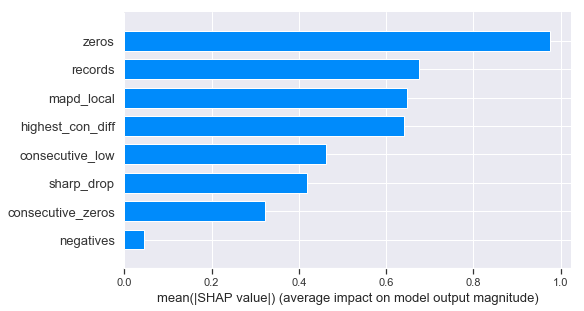

In [208]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X.drop('id_uc', axis=1))
shap.summary_plot(shap_values, X.drop('id_uc', axis=1), plot_type="bar")


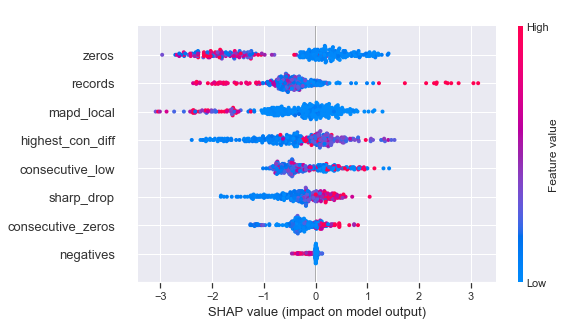

In [209]:
shap.summary_plot(shap_values, X.drop('id_uc', axis=1))


In [210]:
predictions_proba = model.predict(d_test) 
predictions = (model.predict(d_test) > 0.5).astype(int)

In [211]:
true = np.array(y_test)

In [212]:
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        58
           1       0.75      0.33      0.46         9

   micro avg       0.90      0.90      0.90        67
   macro avg       0.83      0.66      0.70        67
weighted avg       0.88      0.90      0.88        67



In [213]:
print(f"F1-Score is {f1_score(true, predictions)}")
print(f"Precision is {precision_score(true, predictions)}")
print(f"Recall is {recall_score(true, predictions)}")
print(f"ROC AUC score is {roc_auc_score(true, predictions)}")

F1-Score is 0.46153846153846156
Precision is 0.75
Recall is 0.3333333333333333
ROC AUC score is 0.6580459770114943


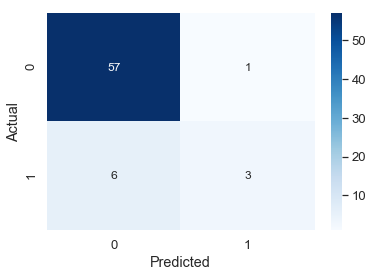

In [214]:
data = confusion_matrix(true, predictions)

df_cm = pd.DataFrame(data, columns=np.unique(true), index = np.unique(true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,4))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

# Validation 

* 2 records with less than 6 points

In [220]:
ts_features_test.query("records < 6").fillna(0)

id_uc  records  negatives     zeros  consecutive_zeros  \
84   100004332575      3.0        0.0  0.333333           0.333333   
215  201074066105      1.0        0.0  0.000000           0.000000   

     sharp_drop  consecutive_low  highest_con_diff  mapd_local  
84     0.333333         0.333333          0.642857   10.288650  
215    0.000000         0.000000          0.000000   14.206311

In [222]:
df_test = ts_features_test.query("records >= 6").fillna(0)

In [226]:
X_test = df_test.drop(['id_uc'], axis=1)

In [230]:
X = X.drop(['id_uc'], axis=1)

In [231]:
d_train = xgb.DMatrix(X, label=y)
d_test = xgb.DMatrix(X_test)

In [234]:
sps = y.value_counts()[0]/y.value_counts()[1]

In [388]:
params = {
    "eta": 0.05,
    "objective": "binary:logistic",
    "max_depth": 5,
    "eval_metric": "logloss",
    "scale_pos_weight": sps,
    "n_jobs": -1,
    "silent": 1,
    "seed": 2147
}
results = {}

model = xgb.train(params, d_train, 500, evals = [(d_train, "train"), (d_train, "train")], verbose_eval=100, early_stopping_rounds=100, evals_result=results)

[0]	train-logloss:0.669202	train-logloss:0.669202
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.123415	train-logloss:0.123415
[200]	train-logloss:0.052129	train-logloss:0.052129
[300]	train-logloss:0.029121	train-logloss:0.029121
[400]	train-logloss:0.021079	train-logloss:0.021079
[499]	train-logloss:0.01727	train-logloss:0.01727


In [389]:
predictions_proba = model.predict(d_test) 
predictions = (model.predict(d_test) > 0.5).astype(int)

In [390]:
final_pred = pd.DataFrame()

In [391]:
final_pred['id_uc'] = df_test['id_uc'].copy()

In [392]:
final_pred['probability'] = pd.Series(list(predictions))

In [394]:
richard_pred = pd.read_csv('rf_results.csv', header=None)

In [395]:
richard_pred.columns = ['id_uc', 'probability_r']

In [396]:
richard_pred['id_uc'] = richard_pred['id_uc'].astype(str)

In [397]:
richard_pred['probability_r']  = (richard_pred['probability_r'] > 0.5).astype(int)

In [398]:
combined_df = final_pred.merge(richard_pred, on='id_uc', how='inner').dropna()

In [399]:
combined_df = combined_df.set_index('id_uc')

In [402]:
combined_df = combined_df.dropna()

In [403]:
combined_df['probability'] = combined_df['probability'].astype(int)

In [406]:
((combined_df['probability'] == 1) &  (combined_df['probability_r'] == 1)).sum()

0

In [378]:
bin

<function bin(number, /)>

In [372]:
(combined_df['probability'] == combined_df['probability_r'])

id_uc
100000017390    False
100000028995    False
100000030011    False
100000031040    False
100000073083    False
                ...  
401019145100    False
401019149104    False
401019151100    False
401019228107    False
401019242104    False
Length: 275, dtype: bool

In [329]:
13/280

0.04642857142857143

In [330]:
21/280

0.075

In [343]:
combined_df.sort_values('probability', ascending=False).index.tolist()[:16]

['100003643615',
 '301009606105',
 '100005004439',
 '100004995370',
 '100003656130',
 '201167176105',
 '100001171416',
 '301009550112',
 '301009605101',
 '301001437100',
 '401003748115',
 '100003656142',
 '100000096307',
 '100006645908',
 '201003597112',
 '201000147107']

id_uc  probability_r
0    100003945383          0.234
1    100003237420          0.000
2    100000673190          0.026
3    100006142832          0.000
4    201167144104          0.258
..            ...            ...
274  100006598062          0.014
275  100004499690          0.000
276  100004863908          0.006
277  100004942481          0.820
278  100005808292          0.000

[279 rows x 2 columns]

id_uc  records  negatives     zeros  consecutive_zeros  \
0    100000017390     44.0   0.000000  0.045455           0.022727   
1    100000028995     53.0   0.018868  0.283019           0.056604   
2    100000030011     53.0   0.075472  0.056604           0.018868   
3    100000031040     53.0   0.037736  0.150943           0.132075   
4    100000073083     53.0   0.000000  0.018868           0.018868   
..            ...      ...        ...       ...                ...   
274  401019151100     44.0   0.000000  0.022727           0.022727   
275  401019228107     44.0   0.000000  0.022727           0.022727   
276  401019242104     44.0   0.000000  0.022727           0.022727   
277  401019248106     44.0   0.000000  0.022727           0.022727   
278  401024679105     51.0   0.000000  0.098039           0.019608   

     sharp_drop  consecutive_low  highest_con_diff  mapd_local  
0      0.022727         0.022727          0.733065   19.751809  
1      0.056604         0.018868          1.878140   38.830645  
2      0.094340         0.037736          1.339725   35.999806  
3      0.056604         0.018868          2.208691    2.001724  
4      0.056604         0.037736          0.780175    0.693329  
..          ...              ...               ...         ...  
274    0.022727         0.022727          0.367638    2.128754  
275    0.022727         0.022727          2.548124    1.049002  
276    0.022727         0.022727          0.781336    0.976226  
277    0.045455         0.045455          0.425921    0.436412  
278    0.019608         0.019608          0.478092    0.503428  

[277 rows x 9 columns]

In [362]:
df.to_csv('jason_training.csv', index=False)

id_uc  records  negatives     zeros  consecutive_zeros  \
0    100000023146     26.0   0.038462  0.115385           0.076923   
1    100000106908     89.0   0.011236  0.022472           0.011236   
2    100000328929    183.0   0.016393  0.158470           0.005464   
4    100000597035    129.0   0.000000  0.449612           0.224806   
5    100000611690     98.0   0.000000  0.948980           0.397959   
..            ...      ...        ...       ...                ...   
345  401005754120     48.0   0.000000  0.083333           0.062500   
346  401016009113    188.0   0.010638  0.005319           0.005319   
347  401017049106    179.0   0.027933  0.033520           0.022346   
348  401021326106    190.0   0.005263  0.010526           0.005263   
349  401048279102    193.0   0.005181  0.005181           0.005181   

     sharp_drop  consecutive_low  highest_con_diff  mapd_local  was_fraud  
0      0.115385         0.038462          0.599139    2.482151          0  
1      0.044944         0.022472          0.837240    3.285958          0  
2      0.005464         0.005464          8.911044    1.298429          0  
4      0.007752         0.007752          2.042415    0.000000          0  
5      0.020408         0.020408          0.164640    0.820731          0  
..          ...              ...               ...         ...        ...  
345    0.041667         0.041667          2.851949    0.349371          1  
346    0.010638         0.010638          1.321296    0.411826          1  
347    0.011173         0.011173          6.076507    6.151642          1  
348    0.005263         0.005263          1.308487    0.985020          1  
349    0.041451         0.010363          1.301701    0.310705          1  

[332 rows x 10 columns]

In [407]:
X_test

records  negatives     zeros  consecutive_zeros  sharp_drop  \
0       44.0   0.000000  0.045455           0.022727    0.022727   
1       53.0   0.018868  0.283019           0.056604    0.056604   
2       53.0   0.075472  0.056604           0.018868    0.094340   
3       53.0   0.037736  0.150943           0.132075    0.056604   
4       53.0   0.000000  0.018868           0.018868    0.056604   
..       ...        ...       ...                ...         ...   
274     44.0   0.000000  0.022727           0.022727    0.022727   
275     44.0   0.000000  0.022727           0.022727    0.022727   
276     44.0   0.000000  0.022727           0.022727    0.022727   
277     44.0   0.000000  0.022727           0.022727    0.045455   
278     51.0   0.000000  0.098039           0.019608    0.019608   

     consecutive_low  highest_con_diff  mapd_local  
0           0.022727          0.733065   19.751809  
1           0.018868          1.878140   38.830645  
2           0.037736          1.339725   35.999806  
3           0.018868          2.208691    2.001724  
4           0.037736          0.780175    0.693329  
..               ...               ...         ...  
274         0.022727          0.367638    2.128754  
275         0.022727          2.548124    1.049002  
276         0.022727          0.781336    0.976226  
277         0.045455          0.425921    0.436412  
278         0.019608          0.478092    0.503428  

[277 rows x 8 columns]

In [409]:
df_test.to_csv('jason_blind_data.csv', index=False)